# 1. Data load

In [1]:
# 기초 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터의 파일 경로 설정 및 파일 이름 확인
import os

path = os.getcwd() + '/data'
data_files = os.listdir(path)
print('Data files: ', data_files)

Data files:  ['sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
train_origin = pd.read_csv(path+'/train.csv')  # train 데이터 불러오기
test_origin = pd.read_csv(path+'/test.csv')    # test 데이터 불러오기
train_origin.shape, test_origin.shape    # 데이터 정보 확인

((20000, 23), (10000, 22))

# 2. Preprocessing

In [4]:
# 데이터 전처리
train = train_origin.copy()
test = test_origin.copy()

# 'Gains', 'Losses', 'Dividends'를 이진 변수로 변환(값이 있으면 1, 없으면 0)
train['Gains'] = train['Gains'].apply(lambda x: 1 if x > 0 else 0)
train['Losses'] = train['Losses'].apply(lambda x: 1 if x > 0 else 0)
train['Dividends'] = train['Dividends'].apply(lambda x: 1 if x > 0 else 0)

In [5]:
# train 데이터에 'Income binary' column 추가
train['Income binary'] = train['Income'].apply(lambda x: 1 if x > 0 else 0)

# Feature Engineering을 위해 test 데이터에도 'Income binary' column 추가
test['Income binary'] = 0

In [6]:
train.shape, test.shape

((20000, 24), (10000, 23))

In [7]:
# Isolation Forest를 이용한 Income의 이상치 제거
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, contamination=0.01, random_state=42)     # 이상치 비율 1%로 설정
clf.fit(train[['Income']])
outlier = clf.predict(train[['Income']])
train['Income_outlier'] = outlier

train = train[train['Income_outlier'] == 1]    # 이상치 제거
train = train.drop(columns=['Income_outlier'])    # 이상치 제거 후 컬럼 삭제

train.reset_index(drop=True, inplace=True)    # 인덱스 재설정

In [8]:
train.shape, test.shape

((19810, 24), (10000, 23))

In [9]:
# Feature Engineering
#all_data = pd.concat([train, test], axis=0)    # train과 test 데이터 병합
#all_data.drop('ID', axis=1, inplace=True)     # ID는 인코딩할 필요 없으므로 제외

#all_data.shape

# Feature Engineering2
all_data = pd.concat([train, test], axis=0)    # train과 test 데이터 병합
all_data.drop(['ID', 'Gains', 'Dividends', 'Household_Status'], axis=1, inplace=True)     # ID는 인코딩할 필요 없으므로 제외

all_data.shape

(29810, 20)

In [10]:
# 명목형과 수치형 자료 분류
#category = ['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']
#numeric = ['Age', 'Working_Week (Yearly)', 'Gains', 'Losses', 'Dividends']

# 명목형과 수치형 자료 분류2
category = ['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']
numeric = ['Age', 'Working_Week (Yearly)', 'Losses']

In [11]:
# 수치형 변수 StandardScaler 적용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_data[numeric] = scaler.fit_transform(all_data[numeric])


# 범주형 변수 인코딩(OHE)
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()
encoded_data = OHE.fit_transform(all_data[category]).toarray()    # OneHotEncoder를 사용하여 범주형 변수 인코딩
encoded_data = pd.DataFrame(encoded_data, columns=OHE.get_feature_names_out(category))    # 인코딩된 데이터를 DataFrame으로 변환

In [12]:
# 다시 train, test 데이터 분할
train = all_data[:len(train)].reset_index(drop=True)
test = all_data[len(train):].reset_index(drop=True)

train_encoded = encoded_data[:len(train)].reset_index(drop=True)
test_encoded = encoded_data[len(train):].reset_index(drop=True)

# 기존의 범주형 변수 제거 후 인코딩된 범주형 변수 추가
train = train.drop(category, axis=1)
train = pd.concat([train, train_encoded], axis=1)

test = test.drop(category, axis=1)
test = pd.concat([test, test_encoded], axis=1)

In [13]:
train.shape, test.shape

((19810, 244), (10000, 244))

In [14]:
# downcast 함수 정의
def downcast(df, verbose=True):     # verbose 옵션 추가: (True)인 경우 몇 퍼센트 압축됐는지 출력
    start_mem = df.memory_usage().sum() / 1024**2   # 초기 메모리 사용량
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{(100*(start_mem - end_mem) / start_mem):.1f}% 압축됨')

    return df

In [15]:
# 메모리 사용량 최적화
train = downcast(train)
test = downcast(test)

87.0% 압축됨
86.9% 압축됨


## (1) 이진 분류기 훈련

In [16]:
# 성능 평가를 위한 함수
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    print('오차행렬 \n', confusion_matrix(y_test, pred))
    print('정확도 :', accuracy_score(y_test, pred))
    print('정밀도 : ',precision_score(y_test, pred))
    print('재현율 :', recall_score(y_test, pred))
    print('f1 score :', f1_score(y_test, pred))
    print('roc auc score :', roc_auc_score(y_test, pred_proba))

In [17]:
# b_train, b_validation 데이터 분할
from sklearn.model_selection import train_test_split
b_train = train.copy()
b_test = test.copy()
b_X_train, b_X_val, b_y_train, b_y_val = train_test_split(b_train.drop(['Income binary', 'Income'], axis=1), b_train['Income binary'], test_size=0.2, random_state=42)

In [18]:
b_X_train.shape, b_X_val.shape, b_y_train.shape, b_y_val.shape

((15848, 242), (3962, 242), (15848,), (3962,))

### (1) 일반 LGBMClassifier

In [19]:
# 데이터로 이진 분류기(LGBMClassifier) 학습
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=400, num_leaves=127, learning_rate=0.01, max_depth=10, n_jobs=-1, random_state=42, objective='binary', boost_from_average=False)

lgbm_clf.fit(b_X_train, b_y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8907, number of negative: 6941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

LGBMClassifier(boost_from_average=False, learning_rate=0.01, max_depth=10,
               n_estimators=400, n_jobs=-1, num_leaves=127, objective='binary',
               random_state=42)

In [20]:
# train 데이터로 성능 평가
pred = lgbm_clf.predict(b_X_train)
pred_proba = lgbm_clf.predict_proba(b_X_train)[:,1]
get_clf_eval(b_y_train, pred, pred_proba)

print('---'*15)

# validation 데이터로 성능 평가
pred = lgbm_clf.predict(b_X_val)
pred_proba = lgbm_clf.predict_proba(b_X_val)[:,1]
get_clf_eval(b_y_val, pred, pred_proba)

오차행렬 
 [[4655 2286]
 [ 167 8740]]
정확도 : 0.8452170620898536
정밀도 :  0.7926718664973699
재현율 : 0.9812507016952958
f1 score : 0.8769377414338033
roc auc score : 0.9027825137071288
---------------------------------------------
오차행렬 
 [[1151  605]
 [  79 2127]]
정확도 : 0.8273599192327108
정밀도 :  0.7785505124450952
재현율 : 0.9641885766092475
f1 score : 0.8614823815309842
roc auc score : 0.8643544629783754


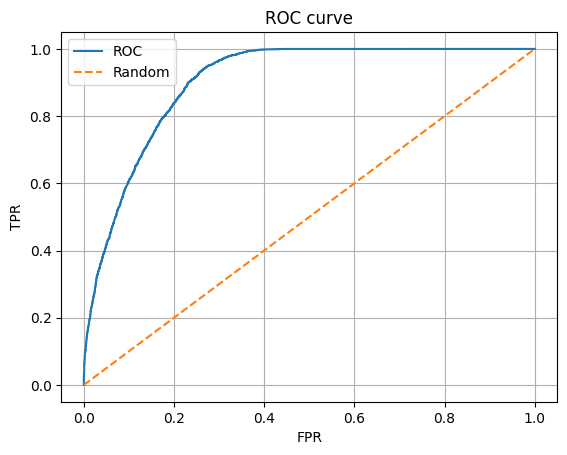

In [21]:
# ROC curve 시각화
from sklearn.metrics import roc_curve

pred_proba = lgbm_clf.predict_proba(b_X_train)[:,1]
fpr, tpr, thresholds = roc_curve(b_y_train, pred_proba)

plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], '--', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.title('ROC curve')
plt.legend()
plt.grid()


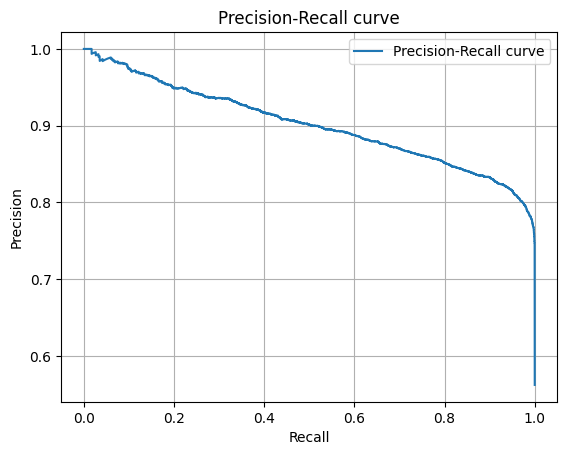

In [22]:
# Precision-Recall curve 시각화
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(b_y_train, pred_proba)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall curve')
plt.legend()
plt.grid()

In [23]:
# Precision이 1.0이 되는 지점의 임계값 출력
optimal_idx = np.argmax(precision)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.8803574925549428

### (2) Precision이 1.0이 되도록 하는 나만의 이진 분류 모델 생성

In [89]:
# b_X_train, b_y_train 데이터로 학습한 이진 분류 모델에서 precision이 1.0이 되도록 하는 나만의 모델 생성
from sklearn.base import BaseEstimator, TransformerMixin

class MyBinaryModel(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        pred_proba = self.model.predict_proba(X)[:, 1]
        pred = np.where(pred_proba > 0.8803574925549428, 1, 0)
        return pred

    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [90]:
# MyModel을 통한 모델 생성
my_clf = LGBMClassifier(n_estimators=400, num_leaves=127, learning_rate=0.01, max_depth=10, n_jobs=-1, random_state=42, objective='binary', boost_from_average=False)
my_binary_model = MyBinaryModel(my_clf)
my_binary_model.fit(b_X_train, b_y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8907, number of negative: 6941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [94]:
# my_model의 성능 평가
pred = my_binary_model.predict(b_X_train)
pred_proba = my_binary_model.predict_proba(b_X_train)[:,1]
get_clf_eval(b_y_train, pred, pred_proba)

print('---'*15)

# validation 데이터로 성능 평가
pred = my_binary_model.predict(b_X_val)
pred_proba = my_binary_model.predict_proba(b_X_val)[:,1]
get_clf_eval(b_y_val, pred, pred_proba)

오차행렬 
 [[6941    0]
 [8754  153]]
정확도 : 0.44762746087834426
정밀도 :  1.0
재현율 : 0.017177500842034354
f1 score : 0.03377483443708609
roc auc score : 0.9027825137071288
---------------------------------------------
오차행렬 
 [[1752    4]
 [2178   28]]
정확도 : 0.44926804644119134
정밀도 :  0.875
재현율 : 0.012692656391659111
f1 score : 0.025022341376228774
roc auc score : 0.8643544629783754


## (2) 회귀 모델 학습

In [28]:
# train, validation 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train.drop(['Income', 'Income binary'], axis=1), train['Income'], test_size=0.2, random_state=42)

In [29]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((15848, 242), (3962, 242), (15848,), (3962,))

In [30]:
# 회귀 모델(LightGBM) 학습
from lightgbm import LGBMRegressor

params = {
    "n_estimators" : 500,
    "learning_rate": 0.01,
    'colsample_bytree': 1.0,
    'max_bin': 324,
    'max_depth': 6,
    'min_child_samples': 144,
    'min_child_weight': 1.0,
    'num_leaves': 125,
    'reg_alpha': 50.0,
    'reg_lambda': 10.0,
    'subsample': 1.0,
    'force_col_wise': True,
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42
    }

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 101
[LightGBM] [Info] Start training from score 520.061522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMRegressor(force_col_wise=True, learning_rate=0.01, max_bin=324, max_depth=6,
              metric='rmse', min_child_samples=144, min_child_weight=1.0,
              n_estimators=500, num_leaves=125, objective='regression',
              random_state=42, reg_alpha=50.0, reg_lambda=10.0)

In [31]:
# 성능 평가
from sklearn.metrics import mean_squared_error

# 훈련 데이터에 대한 예측값
train_pred = lgbm.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f'RMSE: {train_rmse:.4f}')

val_pred = lgbm.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'RMSE: {val_rmse:.4f}')

RMSE: 440.4688
RMSE: 456.7775


## (3) 나만의 모델 학습

In [32]:
train.shape, test.shape

((19810, 244), (10000, 244))

In [81]:
# 데이터로부터 이진 분류를 먼저 진행하고, 이진 분류 결과가 0이 아닌 데이터를 대상으로 회귀 분석을 진행하는 모델
from sklearn.base import BaseEstimator, TransformerMixin

class MyModel(BaseEstimator, TransformerMixin):
    def __init__(self, clf, reg):
        self.clf = clf
        self.reg = reg

    def result(self, X):
        # test data에 대해 이진 분류 수행 후 예측값을 test 데이터에 추가
        total_X = X.copy()
        
        X_clf = X.copy()
        X_clf.drop(['Income', 'Income binary'], axis=1, inplace=True)
        pred_clf = self.clf.predict(X_clf)
        total_X['Income binary'] = pred_clf

        # 이진 분류 결과가 0이 아닌 데이터에 대해 회귀 수행 후 예측값을 test 데이터에 추가
        X_reg = total_X[total_X['Income binary'] != 0].copy()
        X_reg.drop(['Income', 'Income binary'], axis=1, inplace=True)
        pred_reg = self.reg.predict(X_reg)
        
        total_X['Income'] = 0

        # 이진분류 결과가 1인 데이터에 한하여 회귀 모델로 예측값을 대체
        total_X.loc[total_X['Income binary'] != 0, 'Income'] = pred_reg

        return total_X['Income']

In [72]:
# 단순 랜덤 샘플링(random state를 고정하여 난수 초기값 설정)
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(train, test_size = 0.5, random_state=42)

In [73]:
train_set.shape, val_set.shape

((9905, 244), (9905, 244))

### (1) 일반 이진 및 회귀 모델

In [74]:
my_model = MyModel(lgbm_clf, lgbm)

In [75]:
# train set 성능평가
pred = my_model.result(train_set)

RMSE = np.sqrt(mean_squared_error(train_set['Income'], pred))
RMSE

429.8107317763608

In [76]:
# val_set 성능 형가
pred = my_model.result(val_set)
RMSE = np.sqrt(mean_squared_error(val_set['Income'], pred))
RMSE

448.1254513981571

### (2) 나만의 이진 모델 및 회귀 모델

In [95]:
my_model2 = MyModel(my_binary_model, lgbm)

In [96]:
# train set 성능평가
pred = my_model2.result(train_set)

RMSE = np.sqrt(mean_squared_error(train_set['Income'], pred))
RMSE

766.8002025928273

In [98]:
# val_set 성능 형가
pred = my_model2.result(val_set)
RMSE = np.sqrt(mean_squared_error(val_set['Income'], pred))
RMSE

771.3010644359746

# 제출

In [47]:
# 제출용 데이터 확인
submission = pd.read_csv(path+'/sample_submission.csv')
submission.head()

,ID,Income
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [48]:
# 제출용 파일 생성
submission['Income'] = result
submission

,ID,Income
0,TEST_0000,0.000000
1,TEST_0001,0.000000
2,TEST_0002,472.143903
3,TEST_0003,633.558564
4,TEST_0004,0.000000
...,...,...
9995,TEST_9995,1202.543030
9996,TEST_9996,738.439416
9997,TEST_9997,485.350825
9998,TEST_9998,0.000000


In [49]:
submission.to_csv('submission_my_model.csv', index=False)